In [3]:
import numpy as np
import pandas as pd
import os
import sys
import funcs as f
import xarray 

### parameters

In [4]:
outpath       = "/Volumes/Baby-Orange/XPIA-NCAR/processed/"
datapath      = "/Volumes/Baby-Orange/XPIA-NCAR/rawest/"

In [5]:
days = [20,21,28,29,30]

In [17]:
g   = 9.81
cp  = 1004.5

In [52]:
year  = 2015
month = 3

In [60]:
for iday,day in enumerate(days):
    start = pd.Timestamp(year=year,month=month,day=day,hour=14,minute=0)
    end   = pd.Timestamp(year=year,month=month,day=day,hour=23,minute=50)    
    if iday==0:
        desired_idx = pd.date_range(start=start,end=end,freq='10min')
    else:
        desired_idx = desired_idx.append(pd.date_range(start=start,end=end,freq='10min'))

### get density

In [29]:
for iday,day in enumerate(days):
    rho_path = os.path.join(outpath,"RHO_SPATIAL_AVG_15km_by_15km_March{0}.csv".format(day))
    rho_tmp  = pd.read_csv(rho_path, index_col=[0])
    if iday==0:
        rho = rho_tmp.copy()
    else:
        rho = pd.concat([rho,rho_tmp],axis=0)

In [62]:
rho = rho.reindex(desired_idx)

### get hfx

In [65]:
for iday,day in enumerate(days):
    hfx_path = os.path.join(outpath,"HFX_SPATIAL_AVG_15km_by_15km_D02_March{0}.csv".format(day))
    hfx_tmp  = pd.read_csv(hfx_path, index_col=[0], parse_dates=True)
    if iday==0:
        hfx = hfx_tmp.copy()
    else:
        hfx = pd.concat([hfx,hfx_tmp],axis=0)    

In [66]:
hfx = hfx.reindex(desired_idx)

In [108]:
hfx.head()

,1
2015-03-20 14:00:00,NaN
2015-03-20 14:10:00,5.915178
2015-03-20 14:20:00,11.936886
2015-03-20 14:30:00,20.130190
2015-03-20 14:40:00,29.592698


### get layer temp

In [15]:
for iday,day in enumerate(days):
    temp_path = os.path.join(outpath,"T_LAYER_SPATIAL_AVG_15km_by_15km_March{0}.csv".format(day))
    temp_tmp  = pd.read_csv(temp_path, index_col=[0])
    if iday==0:
        temps = temp_tmp.copy()
    else:
        temps = pd.concat([temps,temp_tmp],axis=0)    

In [68]:
temps = temps.reindex(desired_idx)

### get zi

In [19]:
zi       = pd.read_csv("/Volumes/Baby-Orange/XPIA-NCAR/processed/ziL_all_days.csv", header=None, index_col=[0], parse_dates=True)

In [70]:
zi = zi.reindex(desired_idx)

### allocate space

In [72]:
wst = pd.DataFrame(index=desired_idx, columns=temps.columns)

In [73]:
wst.head()

,LES,vles,mynn,ysu,sh
2015-03-20 14:00:00,NaN,NaN,NaN,NaN,NaN
2015-03-20 14:10:00,NaN,NaN,NaN,NaN,NaN
2015-03-20 14:20:00,NaN,NaN,NaN,NaN,NaN
2015-03-20 14:30:00,NaN,NaN,NaN,NaN,NaN
2015-03-20 14:40:00,NaN,NaN,NaN,NaN,NaN


###  compute kinematix heat flux

$ \overline{w' \theta'_v} = Q \rho C_p $

In [83]:
kinematic_flux = np.squeeze(hfx.values / (rho.values * cp))

### compute w*

$w_* = \left[ \frac{g}{T_v} z_i \overline{w' \theta'_v} \right]^{1/3}$

In [112]:
for col in wst.columns:
    p1 = (g/temps[col].values)
    p2 = np.squeeze(zi.values) * kinematic_flux
    wst[col] = (p1 * p2)**(1/3.)

In [113]:
wst.head()

,LES,vles,mynn,ysu,sh
2015-03-20 14:00:00,NaN,NaN,NaN,NaN,NaN
2015-03-20 14:10:00,0.247994,0.247894,0.247921,0.247911,0.247911
2015-03-20 14:20:00,0.352527,0.352307,0.352343,0.352352,0.352352
2015-03-20 14:30:00,0.423640,0.423356,0.423391,0.423420,0.423420
2015-03-20 14:40:00,0.527625,0.527276,0.527317,0.527373,0.527373


# save

In [16]:
days = [20,21,28,29,30]

In [119]:
for day in days:
    daydata = wst.loc['2015-03-{0}'.format(day)].copy()
    daydata = daydata.interpolate(method="index", limit_direction="both")
    #print(".........")
    #print (daydata.head())
    #print (daydata.tail())
    fout = os.path.join(outpath,"WST_SPATIAL_AVG_15km_by_15km_March{0}.csv".format(day))
    print(fout)    
    daydata.to_csv(fout)

/Volumes/Baby-Orange/XPIA-NCAR/processed/WST_SPATIAL_AVG_15km_by_15km_March20.csv
/Volumes/Baby-Orange/XPIA-NCAR/processed/WST_SPATIAL_AVG_15km_by_15km_March21.csv
/Volumes/Baby-Orange/XPIA-NCAR/processed/WST_SPATIAL_AVG_15km_by_15km_March28.csv
/Volumes/Baby-Orange/XPIA-NCAR/processed/WST_SPATIAL_AVG_15km_by_15km_March29.csv
/Volumes/Baby-Orange/XPIA-NCAR/processed/WST_SPATIAL_AVG_15km_by_15km_March30.csv


# plot

In [120]:
colors_days = {20:'#ABB2B9',
               21:'#5DADE2',
               28:'#16A085',
               29:'#D4AC0D',
               30:'#A569BD'}

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fs=16
plt.rc("font",size=fs)

In [126]:
series.index

Index(['2015-03-20 14:00:00', '2015-03-20 14:10:00', '2015-03-20 14:20:00',
       '2015-03-20 14:30:00', '2015-03-20 14:40:00', '2015-03-20 14:50:00',
       '2015-03-20 15:00:00', '2015-03-20 15:10:00', '2015-03-20 15:20:00',
       '2015-03-20 15:30:00', '2015-03-20 15:40:00', '2015-03-20 15:50:00',
       '2015-03-20 16:00:00', '2015-03-20 16:10:00', '2015-03-20 16:20:00',
       '2015-03-20 16:30:00', '2015-03-20 16:40:00', '2015-03-20 16:50:00',
       '2015-03-20 17:00:00', '2015-03-20 17:10:00', '2015-03-20 17:20:00',
       '2015-03-20 17:30:00', '2015-03-20 17:40:00', '2015-03-20 17:50:00',
       '2015-03-20 18:00:00', '2015-03-20 18:10:00', '2015-03-20 18:20:00',
       '2015-03-20 18:30:00', '2015-03-20 18:40:00', '2015-03-20 18:50:00',
       '2015-03-20 19:00:00', '2015-03-20 19:10:00', '2015-03-20 19:20:00',
       '2015-03-20 19:30:00', '2015-03-20 19:40:00', '2015-03-20 19:50:00',
       '2015-03-20 20:00:00', '2015-03-20 20:10:00', '2015-03-20 20:20:00',
       '2015

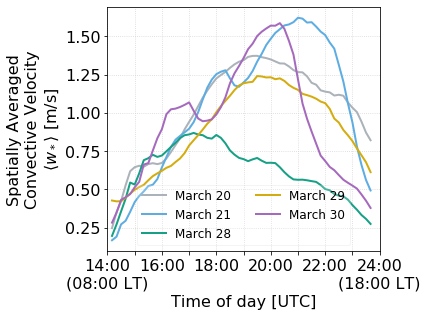

In [138]:
fig = plt.figure(figsize=(6,5))
ax  = fig.add_subplot(111)

iday = 0
for day in days:
    
    fin = os.path.join(outpath,"WST_SPATIAL_AVG_15km_by_15km_March{0}.csv".format(day))
    series = pd.read_csv(fin, index_col=[0], parse_dates=True)       
    series = series["LES"].copy()
    deltas = series.index-series.index[0]+pd.Timedelta('14h')
    index  = start+deltas
    
    ax.plot(index[1:-1],
            series.values[1:-1],color=colors_days[day],linestyle='-',lw=2,
            marker='None',label='March {0}'.format(day))

xticks = index[0::6]
xticks = xticks.append(pd.DatetimeIndex([start+pd.Timedelta('24h')]))
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xticklabels(["14:00\n(08:00 LT)","","16:00","","18:00","","20:00","","22:00","","24:00\n(18:00 LT)"])
ax.set_xlim([xticks[0],xticks[-1]])
ax.set_xlabel("Time of day [UTC]")

ax.grid(color='lightgray',linestyle=':')

ylab       = "Spatially Averaged\nConvective Velocity\n"+r"$\langle w_* \rangle$ [m/s]"
ax.set_ylabel(ylab)

lg = plt.legend(ncol=2,fontsize=12,framealpha=0.2)
fig.subplots_adjust(left=0.25,bottom=0.2,right=0.88)
fig.savefig("../figs/wst_diurnal_cycles.png",dpi=300,bbox_inches="tight")